# **Задание №3**
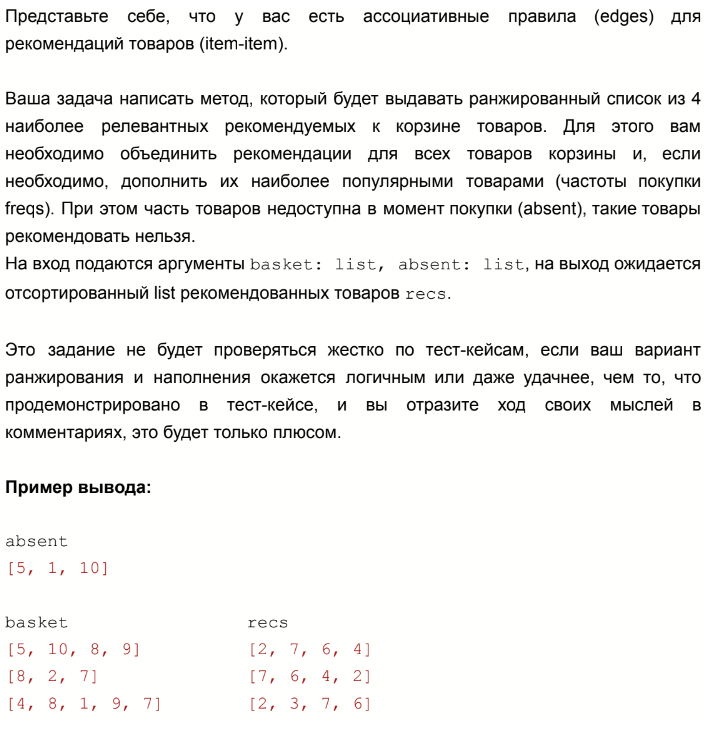

In [ ]:
import pandas as pd
import numpy as np
import random

Создание list из id продуктов

In [ ]:
freqs = [ # Частота для каждого id продукта, представленная в условии задания
[1, 1234],
[2, 1505],
[3, 900],
[4, 2345],
[5, 378],
[6, 2998],
[7, 5421],
[8, 1323],
[9, 708],
[10, 1283]
]
ids = []
for _ in range(len(freqs)):
    ids.append(freqs[_][0])

Количество корзин(сумма id продуктов в представленной выборке, деленное на средний размер корзины)

In [ ]:
n = 0   
for i in range(len(freqs)):
    n += freqs[i][1]
n = round(n/3)

Функция генерирования basket и absent

In [ ]:
def get_basket():
    cnt = random.randint(1,5)
    basket = random.sample(list(ids), cnt)
    return basket

Создание train_data

In [ ]:
def create_train_data():    
    baskets = []
    for _ in range(n):
        baskets.append(get_basket())  # Создание случайно сгенерированной выборки корзин покупателей


    edges_var = []  # Создание всех пар id_a и id_b
    for _ in range(len(ids)*len(ids)):
        if (_//(len(ids)) != _%(len(ids))):
            edges_var.append([ids[_//(len(ids))], ids[_%(len(ids))]])


    edges_df = pd.DataFrame()  # Создание df с частотностью встречаемости пар в выборке(эквивалентно 'edges', предствленного
                               # в условии задания) 
    count = 0
    for _ in range(len(edges_var)):
        for i in range(len(baskets)):
            if (edges_var[_][0] in baskets[i]) & (edges_var[_][1] in baskets[i]):  # Прогон по всем парам, представленным 
                                                                                # в list edges_var и поиск их в выборке baskets 
                count += 1
        data = pd.DataFrame({'para' : [edges_var[_]], 'edges_value' : [count]})
        edges_df = pd.concat([edges_df,data])
        count = 0
    edges_df = edges_df.reset_index(drop=True)
    edges_df['para'].apply(lambda x : x.sort())
    edges_df = edges_df.reset_index(drop=True)
    return edges_df

Проверка на инт

In [ ]:
def isint(s): 
    try:
        int(s)
        return True
    except ValueError:
        return False

Создание корзины   

In [ ]:
def create_basket():  
    basket = []
    thatsAll = False
    while thatsAll == False:  # До тех пор пока покупатель не закончил выбор товаров 
        flag = False
        while flag == False:  # До тех пор пока покупатель не выберит существующий товар  
            id = (input('Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: '))
            if id == 'tl':  # Если покупатель закончил выбор товаров
                thatsAll = True
                break
            flag = isint(id)
            if flag == True:
                if int(id) not in ids: # Если пользователь ввел в строку значеие int, но id такого товара не существует 
                    print('Такого товара у нас нет, попробуйте еще раз')  # Error
                    flag = False
                else:
                    basket.append(int(id))  # Добавление в корзину
            else:
                print('Такого товара у нас нет, попробуйте еще раз')  # Error
    return basket

Поиск рекомендаций 

Условие отбора:

 1) Товар из корзины должен присутствовать в строке df с парами рекомендаций(edges_df)

 2) Хотя бы один из двух товаров, представленный в строке df с парами рекомендаций(edges_df),
 не должен присутствовать в корзине(basket), ибо нелогично рекомендовать покупателю товар,
 который итак лежит у него в корзине

In [ ]:
def research_recs(basket, edges_df):    
    absent = get_basket()  # Создание id товаров, которых нет в наличии
    res = pd.DataFrame({'para' : [], 'edges' : []})  # Создание df с рекомендациями
    for i in range(len(basket)):  # Прогон по всем элементам basket
            for j in range(edges_df.shape[0]):  # Прогон по всем парам рекомендаций
                if basket[i] in edges_df['para'][j]:
                    if (edges_df['para'][j][0] not in basket) | (edges_df['para'][j][1] not in basket):
                        data = pd.DataFrame({'para' : [edges_df['para'][j]], 'edges' : [edges_df['edges_value'][j]]})
                        res = pd.concat([res,data])  # Создание df с парами и их частотностью,
                                                     # которые удовлетворяют условию выше
    res = res.reset_index(drop=True)
    res['para'] = res['para'].apply(tuple, 1).drop_duplicates().apply(list).to_frame()  # Отбрасываем дупликаты, ибо
                                                                                        # [10,1] и [1,10] - одно и тоже(пример)
    res = res.dropna().reset_index(drop=True)  
    for i in range(res.shape[0]):# Отбрасываем из df с парами и их частотностью те товары,
        for j in range(2):       # которые встречаются в basket, чтобы оставить только рекомендованные товары
            if res['para'][i][j] in basket:
                res['para'][i].pop(j)
                break
    res['para'] = res['para'].apply(lambda x: int(x[0]))  # Преобразовываем list'ы рекомендованных товаров в int для удобства 
    res = res.groupby('para', as_index=False).agg({'edges' : 'sum'})  # Группировка df по парам и агрегация по сумме частотности
                                                                      # для кажого рекомендованного товара 
    res = res[~res['para'].isin(absent)].sort_values('edges', ascending=False)  # Сортировка рекомендованных товаров в порядке
                                                                                # возрастания их частотности
    recs = (res['para'].head(4)).tolist()  # Выбор первых четырех рекомендованных товаров  
    print('Ваша корзина: ', basket)
    print('Список товаров, которых нет в наличии: ', absent)
    print('Список рекомендованных товаров: ', recs)

 Таким образом, основная логика для отбора рекомендованных товаров заключается 
 в количестве их встречаемости в первоначльной выборке.
Еще хотелось бы отметить, что поиск рекомендованных товаров может быть основыван на товарах, которых нет в наличии.
 Но он не будет предлагать товары из absent
 То есть если покупатель положил в корзину товар с id = 1, а absent = [1,..], то у нас возможна пара [1,10], к примеру,
где 1 - товар из корзины, 10 - предложенный, и таким образом, товар с id = 10 может попасть в рекомендованный список.

In [ ]:
edges_df = create_train_data()
basket = create_basket()
research_recs(basket, edges_df)

Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: 4
Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: 32
Такого товара у нас нет, попробуйте еще раз
Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: 10
Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: 8
Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: 10
Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: 2
Что вы хотите положить в корзину?(0..10).Чтобы пойти на кассу, введите tl: tl
Ваша корзина:  [4, 10, 8, 10, 2]
Список товаров, которых нет в наличии:  [3, 1, 5, 10]
Список рекомендованных товаров:  [7, 9, 6]
